In [6]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from IPython.display import HTML
import os
import numpy as np

In [7]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [8]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'D:/Masrafe/Coding/Git_Hub_code/ml_project/road_damage/pothole_detection_CNN-main/Dataset',
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 1530 files belonging to 3 classes.


In [9]:
class_names = dataset.class_names
class_names

['Crack', 'Pothole', 'Surface Erosion']

In [10]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[2 2 2 2 2 0 0 2 2 1 1 0 0 2 1 0 1 0 2 0 0 0 2 1 0 0 1 1 0 2 2 1]


In [11]:
len(dataset)

48

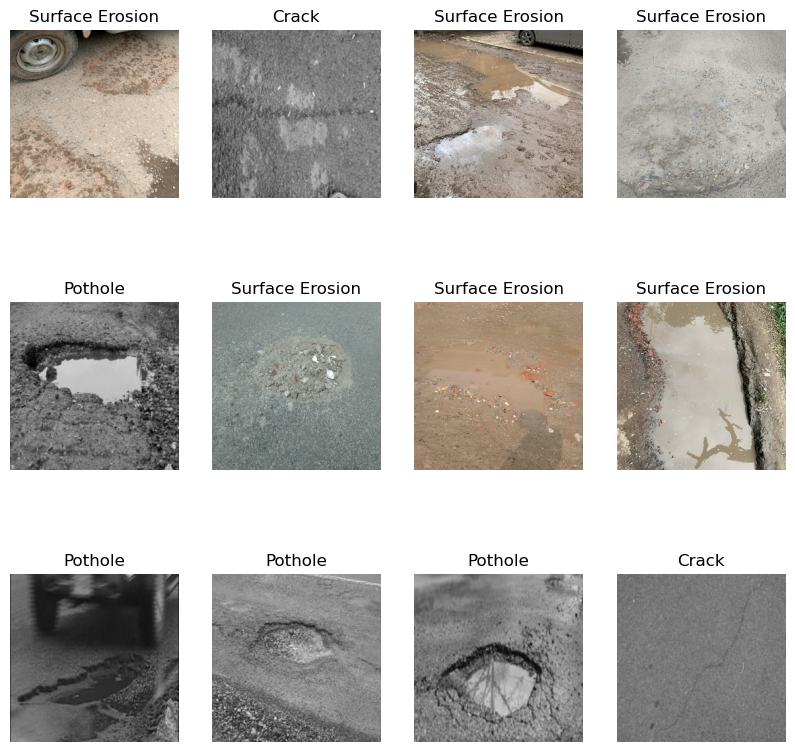

In [12]:
plt.figure(figsize=(10,10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)  
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [13]:
train_size = 0.8
len(dataset)*train_size

38.400000000000006

In [14]:
train_ds = dataset.take(38)
len(train_ds)

38

In [15]:
test_ds = dataset.skip(38)
len(test_ds)

10

In [16]:
val_size=0.1
len(dataset)*val_size

4.800000000000001

In [17]:
val_ds = test_ds.take(4)
len(val_ds)

4

In [18]:
test_ds = test_ds.skip(4)
len(test_ds)

6

In [19]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [20]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [21]:
len(train_ds)

38

In [22]:
len(val_ds)

4

In [23]:
len(test_ds)

6

In [24]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [25]:
resize_and_rescale = Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255)
])

In [26]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [27]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

d:\Masrafe\Coding\python\anaconda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [28]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [30]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 43s 962ms/step - accuracy: 0.4187 - loss: 1.0809 - val_accuracy: 0.4016 - val_loss: 1.0864
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 32s 832ms/step - accuracy: 0.4521 - loss: 1.0585 - val_accuracy: 0.5000 - val_loss: 1.0458
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 36s 943ms/step - accuracy: 0.5352 - loss: 0.9753 - val_accuracy: 0.5492 - val_loss: 0.9096
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.6078 - loss: 0.8592 - val_accuracy: 0.6803 - val_loss: 0.7869
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 33s 860ms/step - accuracy: 0.6718 - loss: 0.7853 - val_accuracy: 0.6148 - val_loss: 0.7482
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 32s 833ms/step - accuracy: 0.6824 - loss: 0.7546 - val_accuracy: 0.6885 - val_loss: 0.7139
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 31s 828ms/step - accuracy: 0.7237 - loss: 0.6491 - val_accuracy: 0.6557 - val_loss: 0.6716
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 32s 836ms/step - accuracy: 0.6899 - loss: 0.6632 - val_accurac

In [31]:
scores = model.evaluate(test_ds)
scores

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 189ms/step - accuracy: 0.9157 - loss: 0.1950


[0.2381545752286911, 0.90625]

In [32]:
history

In [33]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 38}

In [34]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [35]:
history.history['accuracy']

[0.4223140478134155,
 0.4438016414642334,
 0.5537189841270447,
 0.6280992031097412,
 0.655371904373169,
 0.7066115736961365,
 0.7115702629089355,
 0.7008264660835266,
 0.7479338645935059,
 0.7404958605766296,
 0.7190082669258118,
 0.7429752349853516,
 0.7512396574020386,
 0.7644628286361694,
 0.7966942191123962,
 0.7909091114997864,
 0.8231405019760132,
 0.8264462947845459,
 0.815702497959137,
 0.8214876055717468,
 0.8520660996437073,
 0.8388429880142212,
 0.8537189960479736,
 0.8611570000648499,
 0.8611570000648499,
 0.8727272748947144,
 0.8851239681243896,
 0.8892561793327332,
 0.9008264541625977,
 0.8561983704566956,
 0.8975206613540649,
 0.913223147392273,
 0.9206611514091492,
 0.9231404662132263,
 0.93388432264328,
 0.9256198406219482,
 0.9223140478134155,
 0.9173553586006165,
 0.9396694302558899,
 0.952892541885376,
 0.9280991554260254,
 0.937190055847168,
 0.9355372190475464,
 0.9504132270812988,
 0.9586777091026306,
 0.9429752230644226,
 0.9504132270812988,
 0.9471074342727661,

In [36]:
(history.history['loss'])

[1.0775182247161865,
 1.051579475402832,
 0.939082682132721,
 0.830641508102417,
 0.8043591380119324,
 0.7250374555587769,
 0.6674371361732483,
 0.6700122952461243,
 0.6034738421440125,
 0.6208556294441223,
 0.6334640383720398,
 0.588838517665863,
 0.5916455388069153,
 0.5335269570350647,
 0.4911600947380066,
 0.48660707473754883,
 0.4288325011730194,
 0.4225742816925049,
 0.4583020508289337,
 0.4229828417301178,
 0.36217188835144043,
 0.36619803309440613,
 0.35487252473831177,
 0.3220365643501282,
 0.3263321816921234,
 0.3018695116043091,
 0.2756524085998535,
 0.26091229915618896,
 0.26218628883361816,
 0.3375605046749115,
 0.2509603500366211,
 0.22813181579113007,
 0.2015489786863327,
 0.19283518195152283,
 0.1732146143913269,
 0.18570730090141296,
 0.19159701466560364,
 0.1987205147743225,
 0.13721714913845062,
 0.12733137607574463,
 0.18921706080436707,
 0.14338581264019012,
 0.1674681007862091,
 0.12201244384050369,
 0.09521455317735672,
 0.14390501379966736,
 0.12511199712753296,

In [37]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

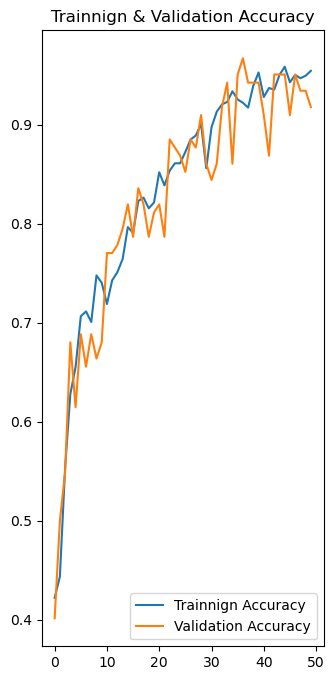

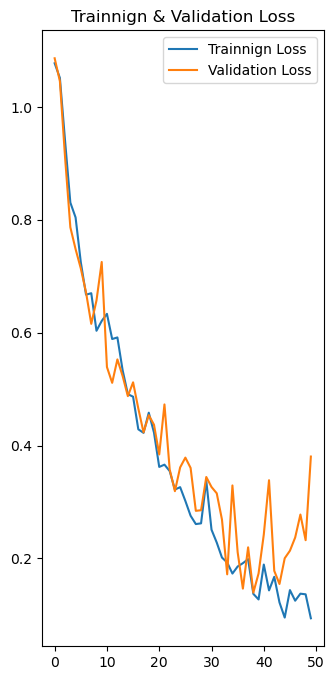

In [38]:
plt.figure(figsize = (8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), accuracy, label = "Trainnign Accuracy")
plt.plot(range(EPOCHS), val_accuracy, label = "Validation Accuracy")
plt.legend(loc = 'lower right')
plt.title("Trainnign & Validation Accuracy")

plt.figure(figsize = (8,8))
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label = "Trainnign Loss")
plt.plot(range(EPOCHS), val_loss, label = "Validation Loss")
plt.legend(loc = 'upper right')
plt.title("Trainnign & Validation Loss")
plt.show()

In [39]:
model.evaluate(train_ds)

38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 181ms/step - accuracy: 0.9644 - loss: 0.1153


[0.09795178472995758, 0.9636363387107849]

First image to predict
First image actual label:  Crack
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
Predicted Label:  Crack


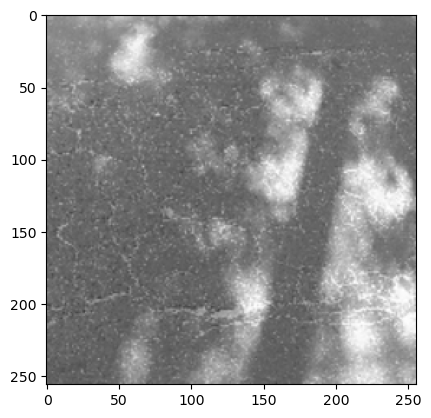

In [40]:
for image_batch, label_batch in test_ds.take(1):
    first_image = (image_batch[0].numpy().astype('uint8'))
    first_label = label_batch[0].numpy()
    
    print("First image to predict")
    plt.imshow(first_image)
    print("First image actual label: ", class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    print("Predicted Label: ",class_names[np.argmax(batch_prediction[0])])

In [41]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    prediction = model.predict(img_array)
    
    predicted_calss = class_names[np.argmax(prediction[0])]
    confidence = round(100 * (np.max(prediction[0])), 2)
    
    return predicted_calss, confidence 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
100.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
100.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
100.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
99.97
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
100.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
100.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
77.12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
99.81
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
97.66


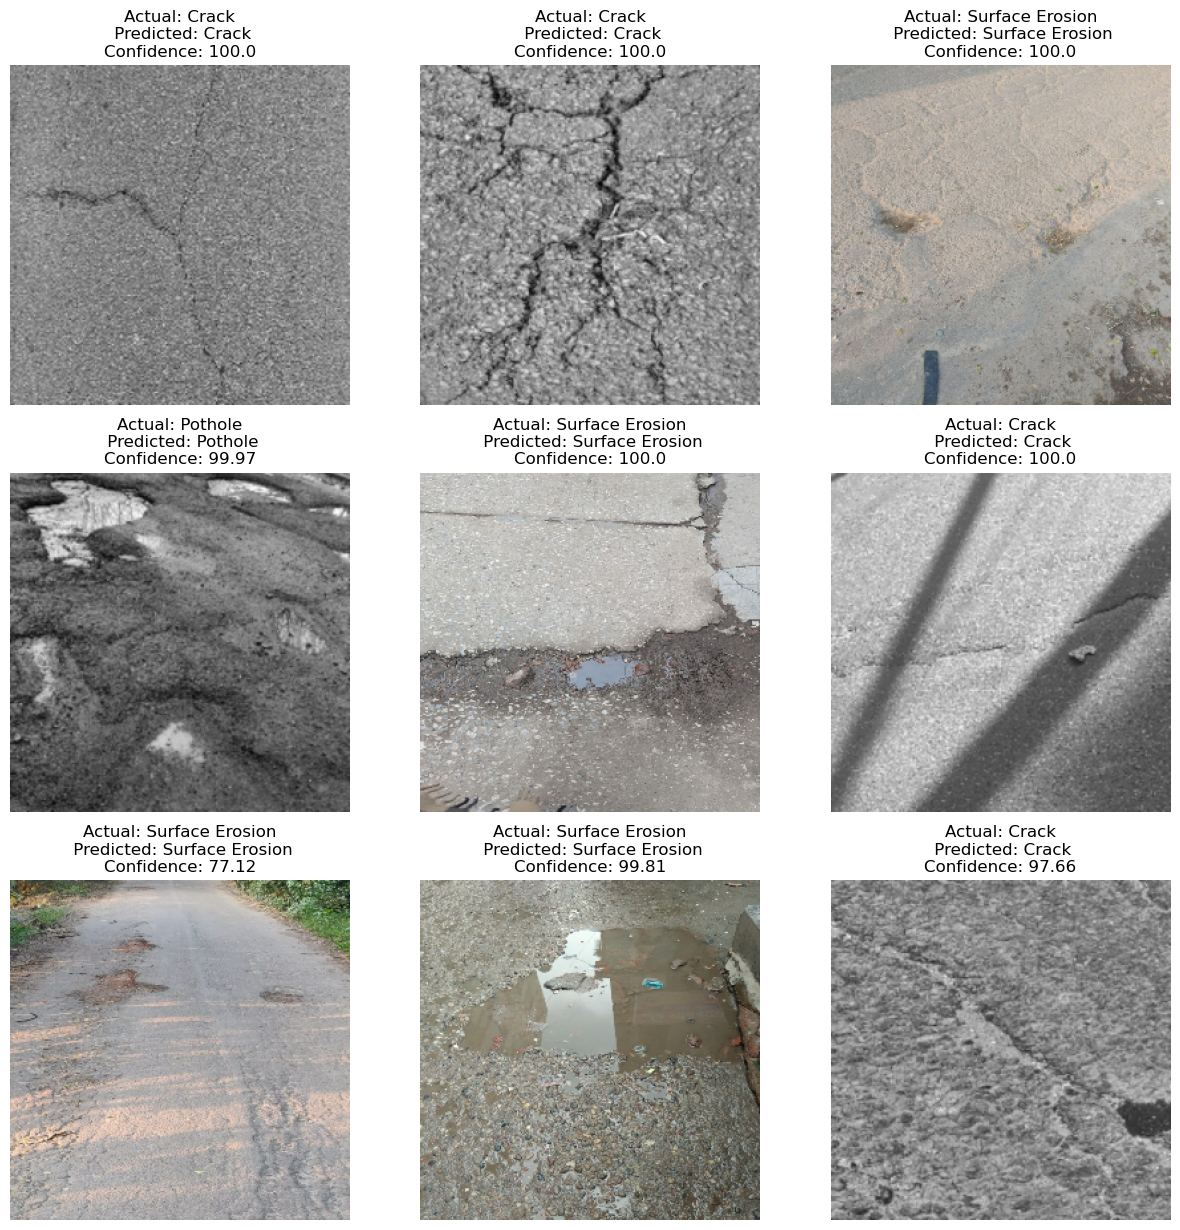

In [42]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, connfidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class}\n Predicted: {predicted_class}\nConfidence: {connfidence}")
        print(connfidence)
        plt.axis("off")

In [43]:
confidence_threshold = 0.8
if connfidence >= confidence_threshold:
    print(f"Prediction: {predicted_class}, Confidence: {connfidence}")
else:
    print("Prediction confidence is too low.")


Prediction: Crack, Confidence: 97.66


In [44]:
from sklearn.metrics import classification_report, f1_score
#Collect true and predicted labels
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

#Calculate F1 score (macro, weighted, etc.)
print("F1 Score (macro):", f1_score(y_true, y_pred, average='macro'))
print("F1 Score (weighted):", f1_score(y_true, y_pred, average='weighted'))

#Optional: Full classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
F1 Score (macro): 0.9061980347694633
F1 Score (weighted): 0.9058201058201059

Classification Report:

                 precision    recall  f1-score   support

          Crack       0.87      0.98      0.92        59
        Pothole       0.90      0.90      0.90        49
Surface Erosion       0.95      0.86      0.90        84

       accuracy                           0.91       192
      macro avg       0.90      0.91      0.91       192
   weighted avg       0.91      0.91      0.91       192



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


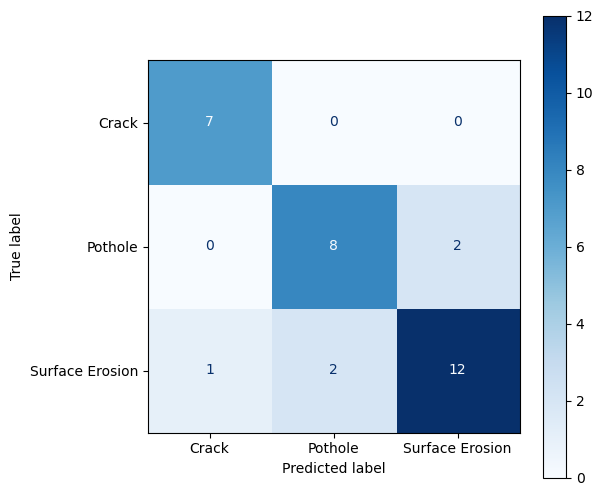

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#Step 1: Get true and predicted labels
y_true = []
y_pred = []

#Loop through test dataset
for images, labels in test_ds:
    predictions = model.predict(images)

#If labels are not one-hot encoded
y_true.extend(labels.numpy())
y_pred.extend(np.argmax(predictions, axis=1))

#Step 2: Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

#Optional: If you want custom class names
class_names = ['Crack', 'Pothole', 'Surface Erosion']  # Replace with your actual class names

#Step 3: Plot and save the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(6, 6))  # Adjust figure size if needed
disp.plot(ax=ax, cmap=plt.cm.Blues)

#Save as image
plt.savefig("confusion_matrix_CNN.png", dpi=300, bbox_inches='tight')
plt.show()